<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [0]:
# Load the first packages we'll need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [0]:
# Read in the text and target dataset from local copy
data_clean = pd.read_csv('data_clean.csv')

In [2]:
# Alternatively, read in the text and target dataset from Google Drive
# Connect to Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Read in dataset from Drive
data_clean = pd.read_csv("/content/drive/My Drive/helpful-reviews/data_clean.csv")
data_clean.drop('Unnamed: 0', axis=1, inplace=True)

# Create boolean column `helpful_1`
data_clean['helpful_1'] = np.where(data_clean['helpful'] > 0, 1, 0)
data_clean.head()

,helpful,text,helpful_1
0,1,I have bought several of the Vitality canned d...,1
1,0,Product arrived labeled as Jumbo Salted Peanut...,0
2,1,This is a confection that has been around a fe...,1
3,3,If you are looking for the secret ingredient i...,1
4,0,Great taffy at a great price. There was a wid...,0


In [3]:
# Find splitting point for 80% train, 10% validation, 10% test
all_length = len(data_clean)
train_len = round(0.8 * all_length)
val_len = round(0.1 * all_length)

print('Train set length:', train_len)
print('Validation set length:', val_len)

Train set length: 314863
Validation set length: 39358


In [0]:
# Train-val-test split
from sklearn.model_selection import train_test_split

y = data_clean['helpful_1']
X = data_clean['text']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=val_len,
                                                    random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                test_size=val_len,
                                                random_state=123)

In [14]:
# Set up stopwords to be removed
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string

stop_list = stopwords.words('english')
stop_list += list(string.punctuation)
stop_list += ['br', '.<', '..', '...', '``', "''", '--', 'http', 'https',
              'com', 'www']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
# Import needed packages/classes
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras import callbacks
from keras.preprocessing import text, sequence
import tensorflow as tf

Using TensorFlow backend.


In [0]:
# Create sequences of tokens uniform in length for all reviews (~ 35 sec.)
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(X_train))
X_train_tok = tokenizer.texts_to_sequences(X_train)
X_train_tok_pad = sequence.pad_sequences(X_train_tok, maxlen=1000)

X_val_tok = tokenizer.texts_to_sequences(X_val)
X_val_tok_pad = sequence.pad_sequences(X_val_tok, maxlen=1000)

In [0]:
# Tokenize the test set
X_test_tok = tokenizer.texts_to_sequences(X_test)
X_test_tok_pad = sequence.pad_sequences(X_test_tok, maxlen=1000)

In [13]:
# Build a GRU network (~ 1:15)
from keras import callbacks

checkpoint = callbacks.ModelCheckpoint('/content/drive/My Drive/helpful-reviews/gru_model_embed_50.h5',
                                       monitor='val_acc', 
                                       save_best_only=True)
early_stop = callbacks.EarlyStopping(monitor='val_loss', 
                                     min_delta=0.001, 
                                     patience=5) 

embed_size = 50
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(200000, embed_size, 
                                    input_shape=(1000,)))
model.add(tf.keras.layers.GRU(25, return_sequences=True, input_shape=(50,)))
model.add(tf.keras.layers.GRU(25, return_sequences=True, input_shape=(50,)))
model.add(tf.keras.layers.GlobalMaxPool1D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='relu'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
history = model.fit(X_train_tok_pad, y_train, epochs=50, batch_size=4096, 
                    validation_data=(X_val_tok_pad, y_val),
                    callbacks=[checkpoint, early_stop])

Train on 314863 samples, validate on 39358 samples
Epoch 1/50
314863/314863 [==============================] - 271s 862us/sample - loss: 1.0192 - acc: 0.5202 - val_loss: 0.7015 - val_acc: 0.5292
Epoch 2/50
314863/314863 [==============================] - 270s 856us/sample - loss: 0.7376 - acc: 0.5171 - val_loss: 0.6943 - val_acc: 0.5292
Epoch 3/50
314863/314863 [==============================] - 267s 847us/sample - loss: 0.7230 - acc: 0.5236 - val_loss: 0.6876 - val_acc: 0.5347
Epoch 4/50
314863/314863 [==============================] - 267s 848us/sample - loss: 0.7135 - acc: 0.5351 - val_loss: 0.6829 - val_acc: 0.5480
Epoch 5/50
314863/314863 [==============================] - 268s 851us/sample - loss: 0.7066 - acc: 0.5465 - val_loss: 0.6872 - val_acc: 0.5442
Epoch 6/50
314863/314863 [==============================] - 268s 852us/sample - loss: 0.7019 - acc: 0.5578 - val_loss: 0.6758 - val_acc: 0.5706
Epoch 7/50
314863/314863 [==============================] - 268s 851us/sample - loss:

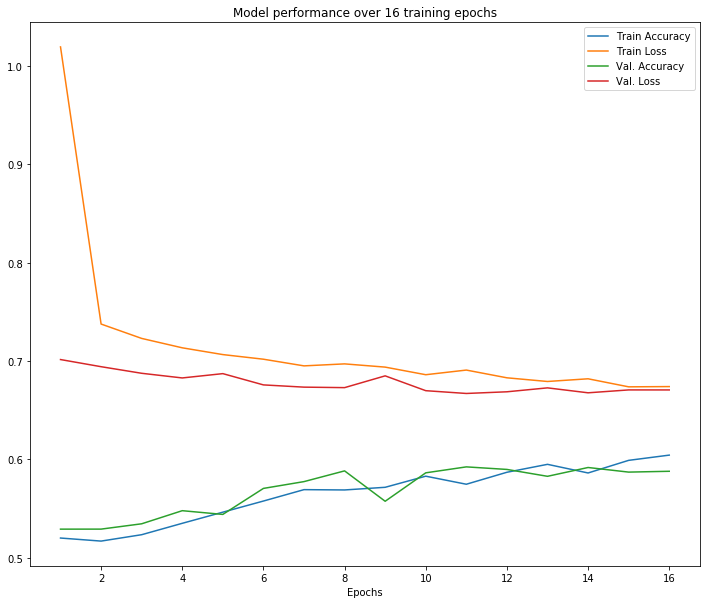

In [16]:
# Visualize loss and accuracy over training epochs
x = [i for i in range(1, 17)]

plt.figure(figsize=(12, 10))
plt.plot(x, history.history['acc'], label='Train Accuracy')
plt.plot(x, history.history['loss'], label='Train Loss')
plt.plot(x, history.history['val_acc'], label='Val. Accuracy')
plt.plot(x, history.history['val_loss'], label='Val. Loss')
plt.title('Model performance over 16 training epochs')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [15]:
# Try a multinomial naive Bayes classifier
# Inspired by https://www.kaggle.com/paragap/amazon-product-rating-prediction-basis-review
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

clf = Pipeline([
    ('vect', CountVectorizer(stop_words=stop_list)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB()),
    ])

nb_clf = clf.fit(X_train, y_train)
print('Accuracy:', nb_clf.score(X_val, y_val))

Accuracy: 0.6005894608465877


In [18]:
# Try a random forest
from sklearn.ensemble import RandomForestClassifier
clf = Pipeline([
    ('vect', CountVectorizer(stop_words=stop_list)),
    ('tfidf', TfidfTransformer()),
    ('classifier', RandomForestClassifier(n_jobs= -1)),
    ])

model = clf.fit(X_train,y_train)
print("Accuracy:", model.score(X_val,y_val))

Accuracy: 0.5905279739824179


In [20]:
# Try a Bernoulli naive Bayes classifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import BernoulliNB

clf = Pipeline([
    ('vect', CountVectorizer(binary=True, stop_words=stop_list)),
    ('classifier', BernoulliNB()),
    ])

bnb_clf = clf.fit(X_train, y_train)
print('Accuracy:', bnb_clf.score(X_val, y_val))

Accuracy: 0.5848620356725444
